In [1]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import time
import re

In [2]:
def ReadData(path,fHead,Cwid='infer',freq=0.5,Zparams=[63.97,47.43,0.0066108,.932]):
    R1=Zparams[0]
    R2=Zparams[1]
    Q=Zparams[2]
    a=Zparams[3]
    
    
    filestr=str(path+fHead+'*'+'.csv.chir')

    all_files=glob.glob(filestr)
    for n in all_files:
    # Getting file index and corresponding voltage from file name    
        try:
            found=re.search('Correct_(.+?)_(.+?)_mV',n)
            Fidx=np.array([int(found.group(1))])
            Vidx=np.array([int(found.group(2))])
        except AttributeError:
            found='no good'
        # Reading data from file
        if Cwid=='infer':
            data=pd.read_fwf(n,colspecs='infer', header=None,engine='python',skiprows=38,dtype=np.double)
            data.columns=('r','Chi_Re','Chi_Im','Chi_Mag','Chi_Phs','Win','deriv_pha')
        else:
            data=pd.read_fwf(n,widths=Cwid, header=None,engine='python',skiprows=38,dtype=np.double)
            data.columns=('r','Chi_Re','Chi_Im','Chi_Mag','Chi_Phs','Win','deriv_pha')

        if n==all_files[0]:
            V=Vidx
            F=Fidx
            eta=Vidx*np.abs(R2/(R1*(1+(2*np.pi*freq*1j*Q)**a*R2)+R2))
            data2=SepRDFData(data,Vidx,Fidx,Vidx)
            
    #         print(Fidx,Vidx, data2.shape)
        else:
            V=np.concatenate((V,Vidx))
            F=np.concatenate((F,Fidx))
            eta=Vidx*np.abs(R2/(R1*(1+(2*np.pi*freq*1j*Q)**a*R2)+R2))
            data2=np.concatenate((data2,SepRDFData(data,Vidx,Fidx,Vidx)),axis=0)
    #         print(Fidx,Vidx, data2.shape)

    #sorting based on file number
    ind=np.argsort(data2[:,8,0],axis=0)
    data2=data2[ind]
    
    return data2
def SepRDFData(datain,V,F,eta):
    r=np.array([datain['r']])
    Chi_Re=np.array([datain['Chi_Re']])
    Chi_Im=np.array([datain['Chi_Im']])
    Chi_Mag=np.array([datain['Chi_Mag']])
    Chi_Phs=np.array([datain['Chi_Phs']])
    Win=np.array([datain['Win']])
    deriv_pha=np.array([datain['deriv_pha']])
    
    dataout=np.array([r,Chi_Re,Chi_Im,Chi_Mag,Chi_Phs,Win,deriv_pha])
    dataout=np.concatenate((dataout,np.tile(V,dataout[0,0,None,None].shape),np.tile(F,dataout[0,0,None,None].shape),np.tile(eta,dataout[0,0,None,None].shape)),axis=0)
    del datain
    return dataout.transpose(1,0,2)

def SepNormData(datain,V,F):
    E=np.array([datain['e']])
    Norm=np.array([datain['norm']])
    nBkg=np.array([datain['nbkg']])
    Flat=np.array([datain['flat']])
    fBkg=np.array([datain['fbkg']])
    nDer=np.array([datain['nder']])
    nSec=np.array([datain['nsec']])
    
    dataout=np.array([E,Norm,nBkg,Flat,fBkg,nDer,nSec])
    dataout=np.concatenate((dataout,np.tile(V,dataout[0,0,None,None].shape),np.tile(F,dataout[0,0,None,None].shape)),axis=0)
    del datain
    return dataout.transpose(1,0,2)


def colorfun(V,Max=1):
    if V>0:
        R=V/Max
        G=0
        B=0
    else:
        R=0
        G=0
        B=-V/Max
    return (R,G,B)

def plotRDF(data,start=0,stop=0,marker='.',in_adjs=[0,0,.1,0,0,.02,0,0],size=(9,6),UseEta=False):

    in_x1adj=in_adjs[0]
    in_x2adj=in_adjs[1]
    in_xint =in_adjs[2]
    in_y1adj=in_adjs[3]
    in_y2adj=in_adjs[4]
    in_yint =in_adjs[5]
    in_xlat=in_adjs[6]
    in_yvert =in_adjs[7]

    title_font = {'fontname':'Arial', 'size':'12', 'color':'black', 'weight':'normal'}
    inset_font = {'fontname':'Arial', 'size':'12', 'color':'black', 'weight':'normal'}
    mpl.rcParams['xtick.labelsize']=12
    mpl.rcParams['ytick.labelsize']=12
    mpl.rcParams['legend.fontsize']=12
    mpl.rcParams['axes.labelsize']=12
    
    MagMaxes=np.max(data[:,3,:],axis=1)
    if UseEta==False:
        MaxV=int(round(np.max(data[:,7,0]),0))
        MinV=int(round(np.min(data[:,7,0]),0))
    else:
        MaxV=int(round(np.max(data[:,9,0]),0))
        MinV=int(round(np.min(data[:,9,0]),0))
        
    ## Plotting full RDF
    fig=plt.figure(constrained_layout=False,figsize=size)
    gs=fig.add_gridspec(3,20)
    f_ax1=fig.add_subplot(gs[:,:-1])
    for n in range(start,data.shape[0]-stop):
        if UseEta==False:
            f_ax1.plot(data[n,0,:].T,data[n,3,:].T,
                     color=(colorfun(data[n,7,0],np.max(data[:,7,0]))),
                     linestyle='-',linewidth=.3,marker=marker,markersize=3,label=str(str(data[n,7,0])+' mV'))
        else:
            f_ax1.plot(data[n,0,:].T,data[n,3,:].T,
                     color=(colorfun(data[n,9,0],np.max(data[:,9,0]))),
                     linestyle='-',linewidth=.3,marker=marker,markersize=3,label=str(str(data[n,7,0])+' mV'))
            
    f_ax1.set(xlim=[0,6])#,yticks=[])
    f_ax1.set_ylabel(r'$FT\/[|\chi\/ k^2|]$  / a.u.',**title_font)
    f_ax1.set_xlabel(r'R  /  $\AA$',**title_font)
    ax1minLoc=mpl.ticker.MultipleLocator(.5)
    f_ax1.xaxis.set_minor_locator(ax1minLoc)


    ## Plotting RDF inset
    f_ax2=fig.add_subplot(gs[:2,10:-1])    
    for n in range(start,data.shape[0]-stop):
        if UseEta==False:
            f_ax2.plot(data[n,0,:].T,data[n,3,:].T,
                     color=(colorfun(data[n,7,0],np.max(data[:,7,0]))),
                     linestyle='-',linewidth=1,marker=marker,markersize=3,label=str(str(data[n,7,0])+' mV'))
        else:
            f_ax2.plot(data[n,0,:].T,data[n,3,:].T,
                     color=(colorfun(data[n,-3,0],np.max(data[:,-3,0]))),
                     linestyle='-',linewidth=1,marker=marker,markersize=3,label=str(str(data[n,7,0])+' mV'))
            
    ## Choosing plot limits for inset
    y1=round(np.max(MagMaxes)*.85,2)
    y2=round(np.max(MagMaxes),1)

    xinds=np.argwhere(data[0,3,:]>=y1)
    x1=round(data[0,0,xinds[0]][0]*.95,2)
    x2=round(data[0,0,xinds[-1]][0]*1.05,2)
    
    f_ax2.set(xlim=[x1+in_xlat+in_x1adj,x2+in_xlat+in_x2adj], xticks=np.arange(x1+in_x1adj,x2+in_x2adj,in_xint),
              ylim=[y1+in_yvert+in_y1adj,y2+in_yvert+in_y2adj], yticks=np.arange(y1+in_y1adj,y2+in_y2adj,in_yint))


    #Plotting colorbar
    f_ax3=fig.add_subplot(gs[:2,-1])
    cdict = {'red':   [(0.0, 0.0, 0.0),
                               (0.5, 0.0, 0.0),
                               (1.0, 1.0, 1.0)],

                     'green': [(0.0, 0.0, 0.0),
                               (0.5, 0.0, 0.0),
                               (1.0, 0.0, 0.0)],

                     'blue':  [(0.0, 1.0, 1.0),
                               (0.5, 0.0, 0.0),
                               (1.0, 0.0, 0.0)],}

    cmap_name = 'my_list'
    cm = mpl.colors.LinearSegmentedColormap(cmap_name, cdict, N=100)
    norm = mpl.colors.Normalize(vmin=MinV, vmax=MaxV)
    cb1=mpl.colorbar.ColorbarBase(f_ax3, cmap=cm,norm=norm,orientation='vertical')
    cb1.set_ticks([MinV,0,MaxV])
    cb1.set_label('mV',rotation=0,labelpad=-3,verticalalignment='center')
    
    return fig
    
def plotMaxes(data,start=0, stop=0,UseEta=False,size=(9,6)):
    
    MagMaxes=np.max(data[:,3,:],axis=1)
    fig2, f2_ax1=plt.subplots(ncols=1,nrows=1,figsize=size)
    
    if UseEta==False:
        f2_ax1.plot(data[start:-1-stop,7,0],MagMaxes[start:-1-stop],'-x')
        f2_ax1.set(xlabel='Applied Voltage \ mV', ylabel=r'Peak of $(FT\/[|\chi k^2|])$ \ a.u.')
        
    else: 
        f2_ax1.plot(data[start:-1-stop,9,0],MagMaxes[start:-1-stop],'-x')
        f2_ax1.set(xlabel='Overpotential \ mV', ylabel=r'Peak of $(FT\/[|\chi k^2|])$ \ a.u.')
    
    return fig2

def plotNorm(data,start=0,stop=0,marker='.',in_adjs=[0,0,.1,0,0,.02],
             startE=7705,stopE=7730,startInE=7718,stopInE=7720,size=(9,6)):
    in_x1adj=in_adjs[0]
    in_x2adj=in_adjs[1]
    in_xint =in_adjs[2]
    in_y1adj=in_adjs[3]
    in_y2adj=in_adjs[4]
    in_yint =in_adjs[5]

    title_font = {'fontname':'Arial', 'size':'12', 'color':'black', 'weight':'normal'}
    mpl.rcParams['xtick.labelsize']=12
    mpl.rcParams['ytick.labelsize']=12
    mpl.rcParams['legend.fontsize']=12
    mpl.rcParams['axes.labelsize']=12

    AbsMax=np.max(data[0,3,:])
    MaxV=int(round(np.max(data[:,7,0]),0))
    MinV=int(round(np.min(data[:,7,0]),0))

    ## Plotting full RDF
    fig=plt.figure(constrained_layout=False,figsize=size)
    gs=fig.add_gridspec(5,20)
    f_ax1=fig.add_subplot(gs[:,:-1])
    for n in range(start,data.shape[0]-stop):

        f_ax1.plot(data[n,0,:].T,data[n,3,:].T,
                 color=(colorfun(data[n,7,0],np.max(data[:,7,0]))),
                 linestyle='-',linewidth=.3,marker='',markersize=3,label=str(str(data[n,7,0])+' mV'))
    f_ax1.set(xlim=[startE,stopE],ylim=[0,1.1*AbsMax])#,yticks=[])
    f_ax1.set_ylabel(r'Normalized Absorption  / a.u.',**title_font)
    f_ax1.set_xlabel(r'Energy  /  eV',**title_font)
    # ax1minLoc=mpl.ticker.MultipleLocator(.5)
    # f_ax1.xaxis.set_minor_locator(ax1minLoc)


    ## Plotting RDF inset
    f_ax2=fig.add_subplot(gs[0:3,2:10])    
    for n in range(start,data.shape[0]-stop):
        f_ax2.plot(data[n,0,:].T,data[n,3,:].T,
                 color=(colorfun(data[n,7,0],np.max(data[:,7,0]))),
                 linestyle='-',linewidth=1,marker=marker,markersize=3,label=str(str(data[n,7,0])+' mV'))

    f_ax2.set(xlim=[startInE,stopInE])

    ## Choosing plot limits for inset

    xind1=np.argwhere(data[0,0,:]>=startInE)[0]
    xind2=np.argwhere(data[0,0,:]<=stopInE)[-1]

    x1=round(data[0,0,xind1][0])
    x2=round(data[0,0,xind2][0])

    y1=round(data[0,3,xind1][0]*.95,2)
    y2=round(data[0,3,xind2][0]*1.05,2)
    
    f_ax2.set(xlim=[x1+in_x1adj,x2+in_x2adj], xticks=np.arange(x1+in_x1adj,x2+in_x2adj,in_xint,**int_font),
              ylim=[y1+in_y1adj,y2+in_y2adj], yticks=np.arange(y1+in_y1adj,y2+in_y2adj,in_yint))


    #Plotting colorbar
    f_ax3=fig.add_subplot(gs[:3,-1])
    cdict = {'red':   [(0.0, 0.0, 0.0),
                               (0.5, 0.0, 0.0),
                               (1.0, 1.0, 1.0)],

                     'green': [(0.0, 0.0, 0.0),
                               (0.5, 0.0, 0.0),
                               (1.0, 0.0, 0.0)],

                     'blue':  [(0.0, 1.0, 1.0),
                               (0.5, 0.0, 0.0),
                               (1.0, 0.0, 0.0)],}

    cmap_name = 'my_list'
    cm = mpl.colors.LinearSegmentedColormap(cmap_name, cdict, N=100)
    norm = mpl.colors.Normalize(vmin=MinV, vmax=MaxV)
    cb1=mpl.colorbar.ColorbarBase(f_ax3, cmap=cm,norm=norm,orientation='vertical')
    cb1.set_ticks([MinV,0,MaxV])
    cb1.set_label('mV',rotation=0, labelpad=-3)
    
    return fig

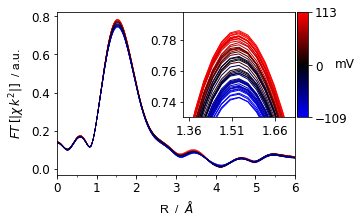

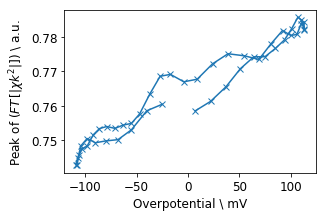

In [3]:
path=r'C:\Users\shadd\OneDrive\Documents\Python\Dynamic XAS\Dynamic XAS Energy analyzed data\ESweep_0_5 Hz\Same Eo\RDF Files'
fHead='\Ir_0_5Hz_ReaddMean_EtaPhsCorrect_'

data=ReadData(path,fHead,freq=0.5)

# plt0=plotRDF(data,start=12,stop=12,in_adjs=[-.03,0,.1,0,0,.02,-.02,.035],size=(4.5,3),UseEta=True)
plt0=plotRDF(data,start=0,stop=0,in_adjs=[0.08,-0.05,0.15,0.05,-0.012,.02,-.02,0.01],size=(4.5,3),UseEta=True,marker='')
plt1=plotMaxes(data,start=0,stop=0, UseEta=True,size=(4.5,3))

# plt0.savefig('0_5Hz_RDF_SameEo_EtaPhs.png', bbox_inches='tight',dpi=500)
# plt1.savefig('0_5Hz_Peak_vs_V_SameEo.png',bbox_inches='tight',dpi=500)

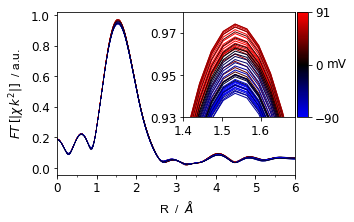

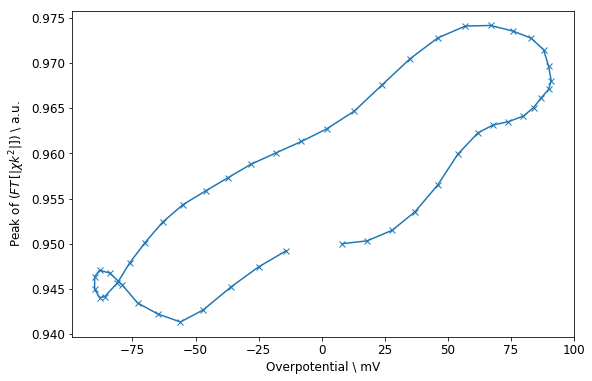

In [4]:
path=r'C:\Users\shadd\OneDrive\Documents\Python\Dynamic XAS\Dynamic XAS Energy analyzed data\ESweep_1 Hz\EtaPhase Corrected'
fHead='\Ir_1Hz_ReaddMean_EtaPhsCorrect_'

data4=ReadData(path,fHead,freq=1)

plt6=plotRDF(data4,start=0,stop=0,in_adjs=[0.12,-0.15,.1,0.1,-0.02,.02,0,0],size=(4.5,3),UseEta=True,marker='')
plt7=plotMaxes(data4,start=0,stop=0,UseEta=True)

# plt6.savefig('1Hz_RDF_SameEo_EtaPhs.png',bbox_inches='tight',dpi=500)
# plt7.savefig('1Hz_Peak_vs_V_PhsCorr_SameEo.png')

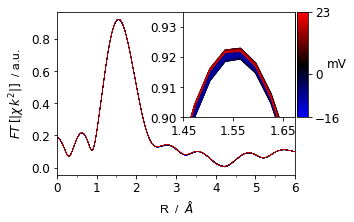

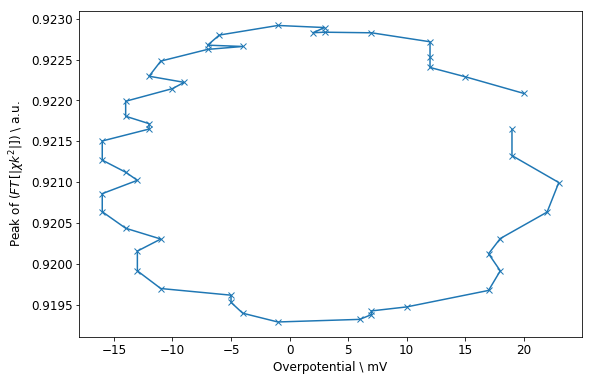

In [5]:
path=r'C:\Users\shadd\OneDrive\Documents\Python\Dynamic XAS\Dynamic XAS Energy analyzed data\ESweep_5 Hz\Same Eo\RDF Files'
fHead='\Ir_5Hz_ReaddMean_EtaPhsCorrect'


data3=ReadData(path,fHead,Cwid=[17,17,17,17,17,17,17],freq=5)
#0.15,-0.13,0.1
plt4=plotRDF(data3,start=0,stop=0,in_adjs=[0.17,-0.195,0.1,0.12,.035,.01,0,0],UseEta=True,size=(4.5,3),marker='')
plt5=plotMaxes(data3,start=0,stop=0,UseEta=True)

# plt4.savefig('5Hz_RDF_SameEo_EtaPhs.png',bbox_inches='tight',dpi=500)
# plt5.savefig('5Hz_Peak_vs_V_SameEo.png')

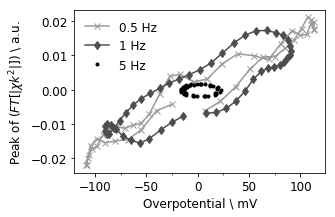

In [6]:
MagMaxes=np.max(data[:,3,:],axis=1)
MagMaxes3=np.max(data3[:,3,:],axis=1)
MagMaxes4=np.max(data4[:,3,:],axis=1)
size=(4.5,3)
UseEta=True
start=0
stop=0

fig2, f2_ax1=plt.subplots(ncols=1,nrows=1,figsize=size)

if UseEta==False:
    f2_ax1.plot(data[start:-1-stop,7,0],MagMaxes[start:-1-stop],'-x')
    f2_ax1.set(xlabel='Applied Voltage \ mV', ylabel=r'Peak of $(FT[|\chi k^2|])$ \ a.u.')

else: 
    f2_ax1.plot(data[start:-1-stop,9,0],MagMaxes[start:-1-stop]-np.mean(MagMaxes[start:-1-stop]),'-x',color='0.6',zorder=2,label='0.5 Hz')
    f2_ax1.plot(data4[start:-1-stop,9,0],MagMaxes4[start:-1-stop]-np.mean(MagMaxes4[start:-1-stop]),'-d',color='0.3',zorder=3,label='1 Hz')
    f2_ax1.plot(data3[start:-1-stop,9,0],MagMaxes3[start:-1-stop]-np.mean(MagMaxes3[start:-1-stop]),'.',color='0',zorder=4,label='5 Hz')
    
    f2_ax1.set(xlabel='Overpotential \ mV', ylabel=r'Peak of $(FT[|\chi k^2|])$ \ a.u.',
              xticks=np.arange(-100,101,50))
    ax1minLoc=mpl.ticker.MultipleLocator(25)
    f2_ax1.xaxis.set_minor_locator(ax1minLoc)
    f2_ax1.legend(frameon=False,shadow=False)
    
    
# fig2.savefig('Peak Maxes v Eta.png',bbox_inches='tight',dpi=500)